In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = 10, 6

In [4]:
%load_ext autoreload
%autoreload 2

In [16]:
import gym

from lspi.util import generate_sample_data

from lspi.policy import RandomPolicy, DiscreteActionBasisPolicy
from lspi.basis import IndActionPolyStateBasis

from lspi.optim import LSPI
from lspi.optim import LSTDQ

# CartPole Debugging

OK, so cartpole isn't working at all.  The policy learnts to move left
in all states.  I might try to get some rendering working real quick just
to make sure I'm not doing anything crazy... I'm missing an OpenGL library 
in this container...  But then I'd have to recreate the container... This
is probably why @cannon used so much docker commit hahaah

## Better Bases

While that's installing / building, let's check out what features we should 
be using.  Shamelessly going to pull from @jack here.  Looks like 
these are the features that work best for CartPole:

```python
def get_cartpole_basis_functions_v2():
    '''
    Returns a list of basis functions that seem 
    to work well for the simplified (no singularity, starting above the horizon)
    cartpole problem.
    
    Note: this one seems to work the best so far.
    '''
    s1 = np.array([1,1,1,1])
    s2 = np.array([0,0,0,0])
    s3 = np.array([1,0,1,0])

    bf1 = lambda s,a: 1

    bf2 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s1)/2.0)
    bf3 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s1)/2.0)

    bf4 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s2)/2.0)
    bf5 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s2)/2.0)

    bf6 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s3)/2.0)
    bf7 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s3)/2.0)
    
    
    bfs = [bf1,bf2, bf3, bf4, bf5, bf6, bf7]
    
    return bfs
```

In [10]:
from environments import NChainEnv

length = 10

# first and last states have a reward
reward = np.zeros(length)
reward[2] = 1
reward[7] = 1

env = NChainEnv(reward, slip=0.0, wrap=False)

In [12]:
data = generate_sample_data(1e4, env, RandomPolicy(env))
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=3)
lstdq = LSTDQ(basis, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [13]:
from lspi.basis import IndActionRBFStateBasis

basis = IndActionRBFStateBasis(list(range(env.observation_space.n)), env.action_space, env.observation_space)
basis(0, 0)

array([ 1.        ,  0.60653066,  0.36787944,  0.22313016,  0.13533528,
        0.082085  ,  0.04978707,  0.03019738,  0.01831564,  0.011109  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [14]:
basis(0, 1)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.60653066,  0.36787944,  0.22313016,  0.13533528,
        0.082085  ,  0.04978707,  0.03019738,  0.01831564,  0.011109  ])

In [17]:
env = gym.make("CartPole-v0")

In [46]:
data = generate_sample_data(1e4, env, RandomPolicy(env))
basis = IndActionRBFStateBasis(np.array([
    np.array([1,1,0.2,1]),
    np.array([0,0,0,0]),
    np.array([1,0,0.2,0])
]), env.action_space, env.observation_space)
lstdq = LSTDQ(basis, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [38]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-3)
lspi.fit(data)

In [39]:
lspi.itr_

3

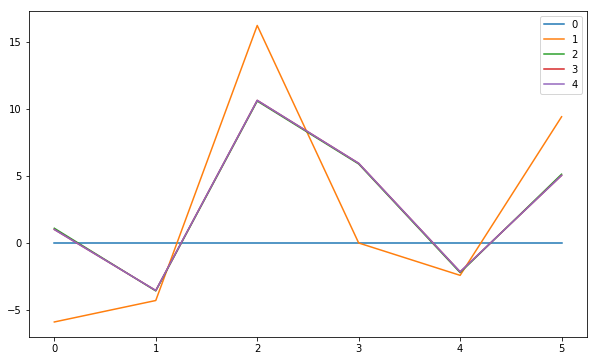

In [40]:
for ind, line in enumerate(lspi.policy.history_):
    plt.plot(line, label=f"{ind}")
plt.legend()

In [41]:
numsteps = []
actions = []

for episode in range(1000):
    state = env.reset()
    done = False
    steps = 0
    while not done:
        action = lspi.policy(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        steps += 1
    numsteps.append(steps)
#     print(f"Episode {episode}, Steps: {steps}")

In [42]:
np.mean(actions)

0.54757901543933396

In [43]:
(np.array(numsteps) > 195).mean()

0.079000000000000001

(array([   1.,    0.,   83.,  250.,  192.,  108.,  110.,  134.,   25.,   97.]),
 array([  33. ,   49.7,   66.4,   83.1,   99.8,  116.5,  133.2,  149.9,
         166.6,  183.3,  200. ]),
 <a list of 10 Patch objects>)

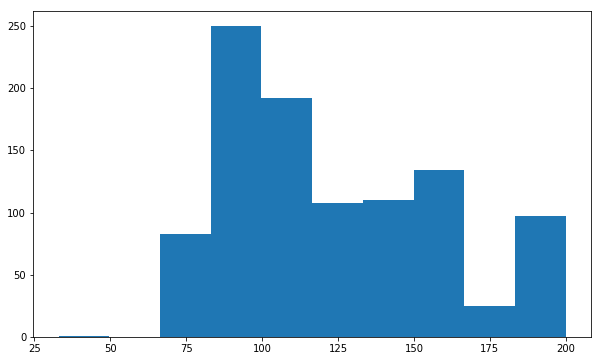

In [44]:
plt.hist(numsteps)

# Rigorous Testing

OK.  So now we know we can actually solve this problem, and we'd like to
explore when this algorithm works and when it doesn't.  To figure out the
best way to go about this this testing, let's list what "knobs" we have
and what "dials" we're looking at:

Knobs:  
* rbf basis: anchor points + how many
* poly basis: order
* discount
* environment
* number of testing episodes
* data
    * quantity
    * distribution (random vs. educated policy)

Dials:  
* total reward
* total steps
* action distribution (since we're working in discrete this is p easy, could estimate some parametric dist. in continuous)


## initial thoughts

* we can sample from our observation space for new anchor points
    * however, since the env. puts a $(-\infty, \infty)$ bound on velocities this will result in poor anchors
    * I can get the bounds from a space and just "clip" them to reasonable amounts and create a new space
* if we want to examine rbf + poly, we need a composite basis.  just going to use RBF for now
* w/ reward + steps we can get avg. reward
* Id like a dictionary for each testing event, as then I can do post-processing in pandas

In [135]:
from lspi.util import BoxAnchorGen

In [136]:
gen = BoxAnchorGen(n=10, space=env.observation_space, low=-10, high=10)
gen = list(gen)
for anch in gen:
    print(anch)

[ 3.5605166   4.18046188  0.29054165  6.70170069]
[-1.62254131  9.98726749 -0.11140626 -6.29185772]
[-4.5954771   2.33261633  0.33222231  1.66064763]
[ 1.57471728 -3.32181382 -0.40348908 -3.81555319]
[-2.40129352 -0.169222    0.27754125  2.92321944]
[ 2.04955292  0.31891954  0.01068337  8.76551247]
[-1.70209336  6.64287424 -0.32288656  6.76946497]
[-3.09957838 -3.77883482 -0.09378404 -2.89221382]
[ 3.11564565 -6.96331549 -0.30222771 -5.6723361 ]
[ 2.52373934 -4.31995249 -0.24049327  2.69021225]


Now we can use this generator in place of previous anchor points.  Now lets
develop a framework for providing our inputs.  Not sure if some sort of 
object or simply a function makes more sense here.

In [137]:
data = generate_sample_data(1e4, env, RandomPolicy(env))
anchors = BoxAnchorGen(n=10, space=env.observation_space, low=-1, high=1)
basis = IndActionRBFStateBasis(anchors, env.action_space, env.observation_space)
lstdq = LSTDQ(basis, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [138]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-3)
lspi.fit(data)

In [139]:
lspi.itr_

4

In [140]:
numsteps = []
actions = []

for episode in range(1000):
    state = env.reset()
    done = False
    steps = 0
    while not done:
        action = lspi.policy(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        steps += 1
    numsteps.append(steps)
#     print(f"Episode {episode}, Steps: {steps}")

In [141]:
(np.array(numsteps) > 195).mean()

0.066000000000000003

(array([  31.,   35.,   34.,   39.,  129.,  154.,  207.,  162.,   98.,  111.]),
 array([  28. ,   45.2,   62.4,   79.6,   96.8,  114. ,  131.2,  148.4,
         165.6,  182.8,  200. ]),
 <a list of 10 Patch objects>)

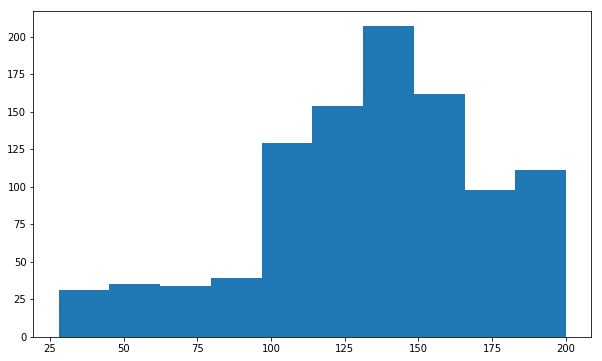

In [142]:
plt.hist(numsteps)

In [144]:
from lspi.policy import Policy

def run_test(policy: Policy, env: gym.Env, num_episodes: int = 100) -> dict:
    numsteps = []
    action_ratio = []
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        steps = 0
        total_reward = 0
        actions = []
        while not done:
            action = policy(state)
            state, reward, done, _ = env.step(action)
            actions.append(action)
            total_reward += reward
            steps += 1
        rewards.append(total_reward)
        numsteps.append(steps)
        action_ratio.append(np.mean(actions))
        
    return {"steps": numsteps, "rewards": rewards, "action_ratio": action_ratio}

In [146]:
results = run_test(lspi.policy, env)

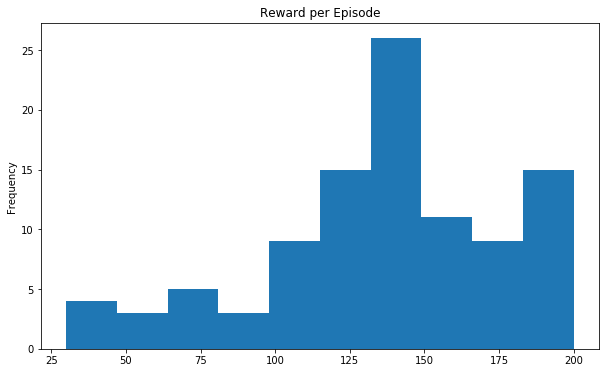

In [157]:
import pandas as pd

pd.DataFrame(results).rewards.plot.hist(title = "Reward per Episode")